# dataset

In [5]:
# Standard library imports
from datetime import datetime, timedelta

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

import time

from scripts.get_top_stocks import *
from scripts.generate_dataset_features import *
from scripts.utils import *
from scripts.dataloader import *
from scripts.train_predict import *
from scripts.models import *

/Users/I748920/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
# top_stocks_long, top_stocks_long_short = generate_top_stocks_df()
# common_top_stocks = get_common_top_stocks(top_stocks_long, top_stocks_long_short)

# # specify variables for dataset generation
# start_date = '2023-01-01'
# end_date = '2024-08-01'
# interval = "1h"
# trading_days_per_year = 252
# hours_per_day = 6.5

In [7]:
# df = get_all_stock_features_df(
#     stocks_list=common_top_stocks,
#     start_date=start_date,
#     end_date=end_date,
#     interval=interval,
#     trading_days_per_year=trading_days_per_year, 
#     hours_per_day=hours_per_day)

In [8]:
# df.to_csv("temp.csv",index=False)

In [7]:
# this is the csv without the target column, if not saved, just uncomment and run the previous 2 cells

df = pd.read_csv("temp.csv")

In [9]:
def set_target(val):
    if val > 0.002:
        return 2
    elif val < -0.002:
        return 0
    else:
        return 1

df['Target'] = df["Log_Return_shift"].apply(lambda x: set_target(x))
df.Target.value_counts()

Target
2    31263
1    29695
0    28981
Name: count, dtype: int64

In [11]:
# additional logic to ensure buy remains +ve and sell remainvs -ve

print(len(df[(df.Log_Return_shift < 0) & (df.Stock_Position == 'buy')]))
# print(len(df[(df.Log_Return_shift < 0) & (df.Stock_Position == 'strong buy')]))

print(len(df[(df.Log_Return_shift > 0) & (df.Stock_Position == 'sell')]))
# print(len(df[(df.Log_Return_shift > 0) & (df.Stock_Position == 'strong sell')]))

# all good

0
0


In [13]:
# sort df according to date
df1 = df.sort_values("Datetime").reset_index(drop=True)

# train test split on index
train_size, val_size, test_size = 0.90, 0.05, 0.05
train_size, val_size, test_size = int(len(df1) * train_size), int(len(df1) * val_size), int(len(df1) * test_size)
train_df = df1.iloc[:train_size]
val_df = df1.iloc[train_size:train_size + val_size]
test_df = df1.iloc[train_size + val_size:]

train_df.shape,val_df.shape,test_df.shape

((80945, 84), (4496, 84), (4498, 84))

In [15]:
# df.columns, df.columns[8:-4]

In [15]:
features = df.columns[8:-4]
print(len(features))
target = "Target"

X_train = train_df[features].to_numpy()
y_train = train_df[target].to_numpy()
print(X_train.shape,y_train.shape)

X_val = val_df[features].to_numpy()
y_val = val_df[target].to_numpy()
print(X_val.shape,y_val.shape)

X_test = test_df[features].to_numpy()
y_test = test_df[target].to_numpy()
print(X_test.shape,y_test.shape)

72
(80945, 72) (80945,)
(4496, 72) (4496,)
(4498, 72) (4498,)


In [17]:
# check number of classes in target is correct

set(y_train),set(y_val),set(y_test)

({0, 1, 2}, {0, 1, 2}, {0, 1, 2})

In [19]:
# standardise the values and PCA

from scripts.train_predict import *

# standardise the values and selectKbest
scaler = StandardScaler()
pca = PCA(n_components = 0.95)

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)
X_train = pca.fit_transform(X_train)

# Transform the validation data
X_val = scaler.transform(X_val)
X_val = pca.transform(X_val)

# Transform the test data
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((80945, 26), (80945,), (4496, 26), (4496,), (4498, 26), (4498,))

In [21]:
# check distribution of target

print(train_df.Target.value_counts())
print(val_df.Target.value_counts())
print(test_df.Target.value_counts())

Target
2    28193
1    26767
0    25985
Name: count, dtype: int64
Target
2    1617
1    1545
0    1334
Name: count, dtype: int64
Target
0    1662
2    1453
1    1383
Name: count, dtype: int64


# pytorch model

In [23]:
# check dataset

print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)
print(type(X_train),type(X_val),type(X_test))
print(type(y_train),type(y_val),type(y_test))

(80945, 26) (80945,) (4496, 26) (4496,) (4498, 26) (4498,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [25]:
# get_numpy_value_counts(y_train),get_numpy_value_counts(y_val),get_numpy_value_counts(y_test)

In [27]:
# define dataset
train_dataset = StockDataset(X=X_train,y=y_train)
val_dataset = StockDataset(X=X_val,y=y_val)
test_dataset = StockDataset(X=X_test,y=y_test)

print(train_dataset.X.shape,val_dataset.X.shape,test_dataset.X.shape)
print(train_dataset.y.shape,val_dataset.y.shape,test_dataset.y.shape)

# define dataloaders
batch_size = 2048

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # set all shuffle=False since its sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# # print to check shape of batches
# for _, batch in enumerate(train_loader):
#     x_batch, y_batch = batch
#     print(x_batch.shape, y_batch.shape)
#     print(x_batch[0], y_batch[0])
#     break

torch.Size([80945, 26]) torch.Size([4496, 26]) torch.Size([4498, 26])
torch.Size([80945]) torch.Size([4496]) torch.Size([4498])


epoch 0
model epoch 0 saved as fcn.pt
Epoch 1/100, train loss: 1.1336, val loss: 1.0805, time_taken: 1.1
train acc: 38.23, val_acc: 39.99
epoch 1
model epoch 1 saved as fcn.pt
Epoch 2/100, train loss: 1.0869, val loss: 1.0786, time_taken: 1.1
train acc: 40.01, val_acc: 40.43
epoch 2
Epoch 3/100, train loss: 1.0803, val loss: 1.0793, time_taken: 1.1
train acc: 40.4, val_acc: 40.77
epoch 3
Epoch 4/100, train loss: 1.0765, val loss: 1.0799, time_taken: 1.1
train acc: 40.93, val_acc: 40.58
epoch 4
Epoch 5/100, train loss: 1.0743, val loss: 1.0798, time_taken: 1.0
train acc: 40.98, val_acc: 40.53
epoch 5
Epoch 6/100, train loss: 1.0733, val loss: 1.0803, time_taken: 1.0
train acc: 41.26, val_acc: 40.55
epoch 6
Epoch 7/100, train loss: 1.0717, val loss: 1.0786, time_taken: 1.0
train acc: 41.57, val_acc: 41.02
epoch 7
model epoch 7 saved as fcn.pt
Epoch 8/100, train loss: 1.0714, val loss: 1.0785, time_taken: 1.1
train acc: 41.42, val_acc: 41.09
epoch 8
Epoch 9/100, train loss: 1.0709, val lo

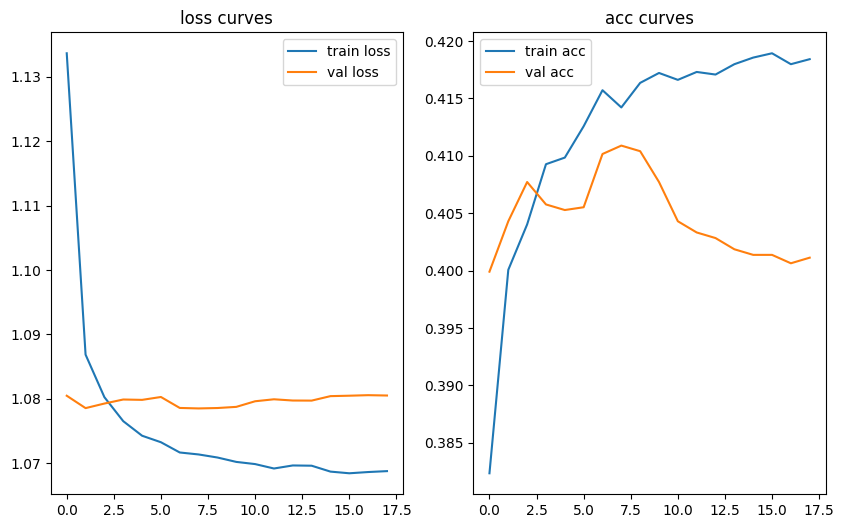

In [29]:
# define model inputs

device = torch.device('cpu')
lr= 1e-3
epochs = 100
scheduler_factor=0.5
scheduler_patience=3
early_stopping_limit = 10
class_weights = [0.889795540181605, 0.6693186731731422, 0.5517017728086973]
criterion = 'cross'
num_features = 26
num_classes = 3

model, train_losses, val_losses, train_accs, val_accs = train(
    device=device,
    lr=lr,
    epochs=epochs,
    scheduler_factor=scheduler_factor,
    scheduler_patience=scheduler_patience,
    early_stopping_limit=early_stopping_limit,
    class_weights=class_weights,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_features=num_features,
    num_classes=num_classes
)
plot_loss_acc(train_losses, val_losses, train_accs, val_accs)

overall test accuracy: 37.26
acc-sell: 1.264
acc-hold: 49.819
acc-buy: 66.483


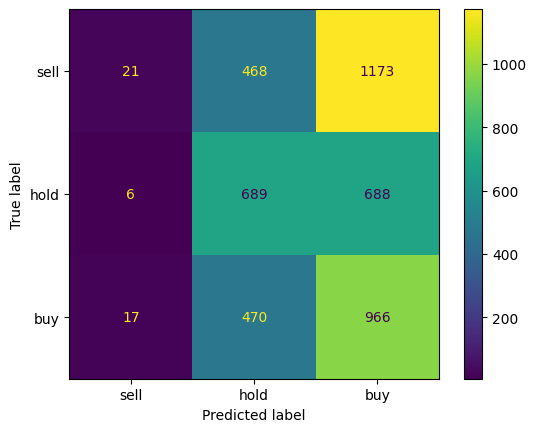

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

best_model_path = 'fcn.pt'
model = FCN(
    num_features=num_features,
    num_classes=num_classes
)
model.load_state_dict(torch.load(best_model_path,map_location=device))
model.eval()


X_test2 = torch.tensor(X_test, dtype=torch.float32)
y_test2 = torch.tensor(y_test, dtype=torch.float32)

preds = model(X_test2)
softmax_preds = nn.Softmax(dim=1)(preds)
_, class_preds = torch.max(preds, dim=1)

test_acc = accuracy_score(class_preds,y_test2)
print(f"overall test accuracy: {round(test_acc*100,2)}")

labels = ["sell","hold","buy"]
label_mapping = {i:labels[i] for i in range(len(labels))}

cm = confusion_matrix(y_test2, class_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
for i in range(len(cm)):
    print(f"acc-{label_mapping[i]}: {round(cm[i,i]/sum(cm[i])*100,3)}")

disp.plot()
plt.show()

In [31]:
# check softmax values

nn.Softmax(dim=1) (preds)

tensor([[0.1949, 0.5152, 0.2899],
        [0.2106, 0.5177, 0.2717],
        [0.1937, 0.5050, 0.3013],
        ...,
        [0.1831, 0.5272, 0.2898],
        [0.2460, 0.3760, 0.3781],
        [0.2362, 0.4446, 0.3192]], grad_fn=<SoftmaxBackward0>)

In [32]:
## predict on indiv stocks

for stock_name in test_df.stock_name.unique():
    stock_df = test_df[test_df['stock_name']==stock_name]
    stock_X_test = stock_df[features].to_numpy()
    # if use selectKbest
    # stock_X_test = selector.transform(stock_X_test)
    # if use PCA
    stock_X_test = pca.transform(stock_X_test)

    stock_y_test = stock_df[target].to_numpy()
    stock_X_test = torch.tensor(stock_X_test, dtype=torch.float32)

    stock_preds = model(stock_X_test)
    softmax_preds = nn.Softmax(dim=1)(stock_preds)
    _, class_preds = torch.max(softmax_preds, dim=1)
    
    acc = accuracy_score(stock_y_test, class_preds.detach().numpy())

    print(f"{stock_name}: {round(acc*100,2)}")

# # choose top 10 from here

RR.L: 28.92
MKS.L: 37.35
III.L: 31.33
MELI: 38.4
INTU: 26.4
SMCI: 33.6
WDAY: 28.8
META: 31.2
BKNG: 28.0
ABNB: 26.4
TSLA: 38.4
ADBE: 31.2
TEAM: 31.2
AMD: 34.4
AMZN: 30.4
DASH: 36.8
DDOG: 36.8
SNPS: 32.0
TTD: 32.8
NVDA: 37.6
AMAT: 36.0
MDB: 32.0
LRCX: 33.6
CRWD: 33.6
AVGO: 39.2
PANW: 32.0
INTC: 29.6
MSFT: 23.2
CDNS: 27.2
MU: 29.6
MRVL: 36.8
MRNA: 33.6
ZS: 32.8
PDD: 28.8
CPRT: 26.4


In [33]:
stock_name = "TTD"

stock_df = test_df[test_df['stock_name']==stock_name]
stock_X_test = stock_df[features].to_numpy()
# if use selectKbest
# stock_X_test = selector.transform(stock_X_test)
# if use PCA
stock_X_test = pca.transform(stock_X_test)

stock_y_test = stock_df[target].to_numpy()
stock_X_test = torch.tensor(stock_X_test, dtype=torch.float32)

stock_preds = model(stock_X_test)
softmax_preds = nn.Softmax(dim=1)(stock_preds)
_, class_preds = torch.max(softmax_preds, dim=1)

acc = accuracy_score(stock_y_test, class_preds.detach().numpy())

print(f"{stock_name}: {round(acc*100,2)}")

TTD: 32.8


In [34]:
softmax_preds[:10]

tensor([[0.3927, 0.2396, 0.3677],
        [0.2476, 0.3721, 0.3803],
        [0.3457, 0.2311, 0.4232],
        [0.3182, 0.2736, 0.4082],
        [0.3013, 0.2843, 0.4145],
        [0.3832, 0.3385, 0.2782],
        [0.2885, 0.3855, 0.3260],
        [0.3129, 0.3495, 0.3376],
        [0.2659, 0.3286, 0.4056],
        [0.2945, 0.2666, 0.4389]], grad_fn=<SliceBackward0>)

In [35]:
def threshold_pred(softmax_pred,thre_buy=0.7,thre_sell=0.7):
    if softmax_pred[2] >= thre_buy:
        return 2
    elif softmax_pred[0] >= thre_sell:
        return 0
    else:
        # just hold
        return 1

def get_threshold_preds(softmax_preds,thre_buy=0.7,thre_sell=0.7):
    res = []
    for softmax_pred in softmax_preds:
        pred = threshold_pred(softmax_pred,thre_buy,thre_sell)
        res.append(pred)
    return res

In [36]:
len(stock_y_test)

125

accuracy: 35.2


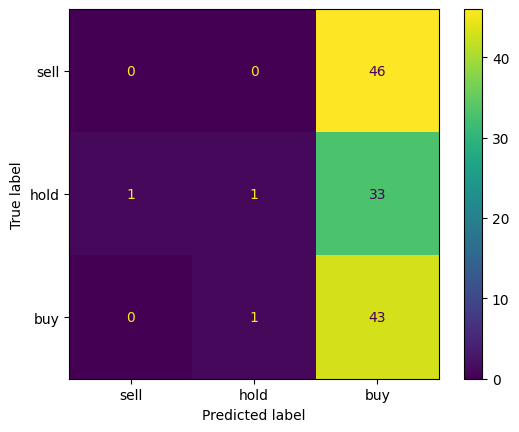

In [37]:
thre_preds = get_threshold_preds(softmax_preds,thre_buy=0.33333,thre_sell=0.303333)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

acc = accuracy_score(thre_preds,stock_y_test)
print(f"accuracy: {round(acc*100,2)}")

cm = confusion_matrix(stock_y_test, thre_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

In [38]:
## predict on top 10 stocks

stock_list =[
    "DDOG",
    "SNPS",
    "BKNG",
    "SMCI",
    "MDB",
    "NVDA",
    "MELI",
    "WDAY",
    "RR.L",
    "PDD",
]

for stock_name in stock_list:
    stock_df = test_df[test_df['stock_name']==stock_name]
    stock_X_test = stock_df[features].to_numpy()
    # if use selectKbest
    # stock_X_test = selector.transform(stock_X_test)
    # if use PCA
    stock_X_test = pca.transform(stock_X_test)

    stock_y_test = stock_df[target].to_numpy()
    stock_X_test = torch.tensor(stock_X_test, dtype=torch.float32)

    stock_preds = model(stock_X_test)
    softmax_preds = nn.Softmax(dim=1)(stock_preds)
    _, class_preds = torch.max(softmax_preds, dim=1)
    
    acc = accuracy_score(stock_y_test, class_preds.detach().numpy())

    print(f"{stock_name}: {round(acc*100,2)}")

# # choose top 10 from here

DDOG: 36.8
SNPS: 32.0
BKNG: 28.0
SMCI: 33.6
MDB: 32.0
NVDA: 37.6
MELI: 38.4
WDAY: 28.8
RR.L: 28.92
PDD: 28.8


# pnl calc

In [141]:
import pandas as pd
from datetime import datetime

# Convert the datetime column to datetime objects
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Define the date threshold (July 1, 2024)
date_threshold = datetime.strptime('2024-07-01 00:00:00-00:00', '%Y-%m-%d %H:%M:%S%z')

# Filter the DataFrame for dates after July 1, 2024
test_df = df[df['Datetime'] > date_threshold]

# Print the filtered DataFrame
test_df

/var/folders/ff/wvby4kh52j96myw15h33jjk40000gn/T/ipykernel_95996/254771661.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Datetime'] = pd.to_datetime(df['Datetime'])


,Datetime,Open,High,Low,Close,Adj Close,Volume,Log_Return,EMAVolumeDiff2,SMAVolumeDiff2,...,MACD16,MACD32,MACD64,MACD128,MACD256,FamaFrenchMktReturns,Log_Return_shift,stock_name,Stock_Position,Target
2354,2024-07-01 09:30:00-04:00,160.819992,161.733994,159.350006,161.067001,161.067001,1342531,0.003308,0.170771,0.151327,...,0.511019,-1.006622,-0.556906,13.806990,-20.697671,0.68,-0.001277,AVGO,sell,1
2355,2024-07-01 10:30:00-04:00,161.097000,161.595993,159.962997,160.861496,160.861496,669604,-0.001277,-0.191922,-0.334434,...,1.544406,-1.466444,-0.736640,55.247094,-13.891604,0.68,0.014929,AVGO,strong buy,2
2356,2024-07-01 11:30:00-04:00,160.747192,163.705002,160.689606,163.281006,163.281006,674940,0.014929,-0.070552,0.003969,...,0.384979,-0.249043,-0.191425,1.622364,4.544833,0.68,0.002025,AVGO,buy,2
2357,2024-07-01 12:30:00-04:00,163.219803,164.875000,162.712006,163.612000,163.612000,545772,0.002025,-0.099246,-0.105814,...,0.714899,-0.171963,-0.161099,1.505700,3.953945,0.68,-0.005021,AVGO,strong sell,0
2358,2024-07-01 13:30:00-04:00,163.587997,163.619995,162.519989,162.792587,162.792587,281924,-0.005021,-0.276966,-0.318774,...,4.339257,-0.221134,-0.218979,2.344831,6.734917,0.68,0.005278,AVGO,strong buy,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89934,2024-07-30 13:30:00-04:00,103.071098,104.070000,102.940002,103.919998,103.919998,2017796,0.007826,-0.128269,-0.196618,...,4.539734,1.431240,1.318580,1.077183,0.431512,0.68,-0.005984,MU,strong sell,0
89935,2024-07-30 14:30:00-04:00,103.919998,104.410004,103.260002,103.300003,103.300003,1907208,-0.005984,-0.066485,-0.028175,...,2.530786,1.300820,1.227392,1.019769,0.421125,0.68,-0.007384,MU,strong sell,0
89936,2024-07-30 15:30:00-04:00,103.269997,103.349998,102.379997,102.540001,102.540001,2991108,-0.007384,0.118136,0.221280,...,1.852822,1.158428,1.116428,0.948070,0.405730,0.68,0.068999,MU,strong buy,2
89937,2024-07-31 09:30:00-04:00,109.800003,110.812401,108.160004,109.864998,109.864998,7445316,0.068999,0.271565,0.426794,...,-0.201396,-0.433364,-1.071457,-3.287237,1.876995,0.68,0.003045,MU,buy,2


In [147]:
target

'Target'

In [213]:
def model_to_portfolio(test_df, features, target, model):
    
    res = pd.DataFrame()
    for ticker in test_df.stock_name.unique():
        stock_df = test_df[test_df['stock_name']==ticker]
        stock_X_test = stock_df[features].to_numpy()
        stock_X_test = pca.transform(stock_X_test)

        stock_X_test = torch.tensor(stock_X_test, dtype=torch.float32)
        stock_preds = model(stock_X_test)

        _, class_preds = torch.max(stock_preds, dim=1)
        class_preds = class_preds.detach().numpy()
        res[ticker] = pd.Series(class_preds)
        
        
    res = res.replace({0:-1, 1:0, 2:1})
    # res['Date'] = date
    # res = res.set_index('Date')
    res = res.astype('int16')
    res['total'] = res.apply(lambda x: np.sum(np.abs(x)), axis=1)
    res = res.div(res['total'], axis=0)
    res.drop(columns=['total'], inplace=True)

    return res


res = model_to_portfolio(test_df, features, target, model)

In [211]:
res

,AVGO,CRWD,AMD,ZS,MRVL,TEAM,SNPS,INTU,TTD,INTC,...,PANW,MDB,CDNS,DDOG,DASH,PDD,RR.L,BKNG,SMCI,MU
0,0.028571,-0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,-0.028571,0.028571,...,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571
1,0.032258,0.032258,0.032258,0.032258,-0.032258,0.032258,0.032258,0.032258,0.000000,0.032258,...,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.000000,0.032258,0.032258
2,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,...,0.030303,0.030303,-0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303
3,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,-0.033333,0.033333,0.033333,-0.033333,...,0.033333,0.033333,0.033333,0.033333,0.000000,0.033333,0.033333,0.033333,0.033333,0.033333
4,0.029412,0.029412,0.029412,0.029412,-0.029412,0.029412,0.029412,0.000000,0.029412,-0.029412,...,0.029412,0.029412,-0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,...,0.031250,0.031250,0.031250,0.000000,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250
141,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,...,0.028571,-0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571
142,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,...,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,-0.028571,0.028571,0.028571,0.028571
143,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,...,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571,0.028571


# inference.py

In [224]:
import torch.nn as nn
import torch.nn.functional as F

class FCN(nn.Module):
    def __init__(self,num_features,num_classes):        
        super(FCN, self).__init__()
        self.fcn = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.Tanh(),
            nn.Dropout(0.5),          
            
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.fcn(x)
        return x


def load_model(model_path,num_features=26,num_classes):
    model = FCN(
        num_features=num_features,
        num_classes=num_classes
    )
    model.load_state_dict(torch.load(best_model_path,map_location=device))
    model.eval()

    return model

In [221]:
model_path = 'fcn.pt'

model = load_model(model_path=model_path)

TypeError: __init__() missing 2 required positional arguments: 'num_features' and 'num_classes'

In [ ]:
def evaluate(X_test,y_test):
    criterion = nn.CrossEntropyLoss()

    # load best pretraining model
    best_model_path = 'fcn.pt'
    model = FCN()
    model.load_state_dict(torch.load(best_model_path,map_location=device))
    model.eval()

    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    preds = model(X_test.to(device))
    softmax_preds=nn.Softmax(dim=1)(preds)
    test_loss = criterion(softmax_preds,y_test.long())
    print("test loss: ",test_loss)
    test_acc = round(get_accuracy(softmax_preds,y_test)*100,2)
    print("test acc: ",test_acc)
    
    return preds